Tutorial extraído da documentação oficial do [Pytorch - NLP FROM SCRATCH: TRANSLATION WITH A SEQUENCE TO SEQUENCE NETWORK AND ATTENTION](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)

In [ ]:
import os

In [ ]:
os.chdir('/content/drive/MyDrive/doutorado/topicos nlp/attention')

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading data files

In [ ]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [ ]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [ ]:
!ls

decoder_weights.pth  encoder_weights.pth  por.txt


In [ ]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('por.txt', encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')[:2]] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [ ]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [ ]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'port', True)
print(random.choice(pairs))

Reading lines...
Read 177741 sentence pairs
Trimmed to 11496 sentence pairs
Counting words...
Counted words:
port 3907
eng 2806
['estou maravilhado com tua fluencia em frances .', 'i m amazed at your fluency in french .']


## Seq2Seq Model

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Training

In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [ ]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [ ]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

## Plotting results

In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

## Evaluation

In [ ]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('Entrada: ', pair[0])
        print('Tradução: ', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('Saída: ', output_sentence)
        print('')

## Training and evaluating

In [ ]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

#

In [ ]:
trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

1m 56s (- 27m 7s) (5000 6%) 2.8665
3m 47s (- 24m 38s) (10000 13%) 2.2665
5m 38s (- 22m 34s) (15000 20%) 1.9150
7m 30s (- 20m 39s) (20000 26%) 1.6540
9m 23s (- 18m 46s) (25000 33%) 1.4843
11m 15s (- 16m 53s) (30000 40%) 1.3006
13m 7s (- 14m 59s) (35000 46%) 1.1506
15m 0s (- 13m 8s) (40000 53%) 1.0240
16m 53s (- 11m 15s) (45000 60%) 0.9277
18m 44s (- 9m 22s) (50000 66%) 0.8567
20m 38s (- 7m 30s) (55000 73%) 0.7919
22m 31s (- 5m 37s) (60000 80%) 0.7178
24m 25s (- 3m 45s) (65000 86%) 0.6802
26m 17s (- 1m 52s) (70000 93%) 0.6475
28m 10s (- 0m 0s) (75000 100%) 0.5917


In [ ]:
n_iters = 7500
training_pairs = [tensorsFromPair(random.choice(pairs))
                    for i in range(n_iters)]
training_pair = training_pairs[0]
input_tensor = training_pair[0]
target_tensor = training_pair[1]

In [ ]:
input_tensor,target_tensor

(tensor([[  5],
         [193],
         [  9],
         [135],
         [531],
         [  4],
         [  1]], device='cuda:0'), tensor([[  2],
         [  3],
         [135],
         [322],
         [369],
         [  5],
         [  1]], device='cuda:0'))

In [ ]:
input_length = input_tensor.size(0)
target_length = target_tensor.size(0)

In [ ]:
input_tensor[0]

tensor([5], device='cuda:0')

In [ ]:
encoder_hidden = encoder1.initHidden()
encoder_hidden.shape

torch.Size([1, 1, 256])

In [ ]:
emb = encoder1.embedding(input_tensor[0]).view(1,1,-1)

In [ ]:
output,hidden = encoder1.gru(emb,encoder_hidden)

In [ ]:
output.shape

torch.Size([1, 1, 256])

In [ ]:
evaluateRandomly(encoder1, attn_decoder1)

Entrada:  agora estou um pouco ocupado tom .
Tradução:  i m kind of busy right now tom .
Saída:  i m kind of busy right now tom . <EOS>

Entrada:  estou farta de ficar aqui .
Tradução:  i m sick of being here .
Saída:  i m sick of here . <EOS>

Entrada:  desculpe me isso nunca acontecera novamente .
Tradução:  i m sorry that ll never happen again .
Saída:  i m sorry that never never that again . <EOS>

Entrada:  ela vem da franca .
Tradução:  she is from france .
Saída:  she is from france . <EOS>

Entrada:  voce e impulsivo .
Tradução:  you re impulsive .
Saída:  you re impulsive . <EOS>

Entrada:  estamos todos animados .
Tradução:  we re all excited .
Saída:  we re all ready . <EOS>

Entrada:  sou um inspetor .
Tradução:  i m a surveyor .
Saída:  i m a student . <EOS>

Entrada:  eu estou farto de suas reclamacoes .
Tradução:  i m sick of your complaints .
Saída:  i m sick of your complaints . <EOS>

Entrada:  sao cantoras .
Tradução:  they are singers .
Saída:  they re singers . <EO

## Visualizing Attention

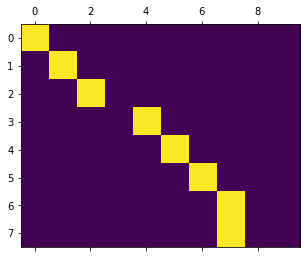

In [ ]:
%matplotlib inline
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "eu tambem estou preocupado com tom .")
plt.matshow(attentions.numpy())

input = sobre a morte de presidente  .
output = i m eating of our of our . <EOS>


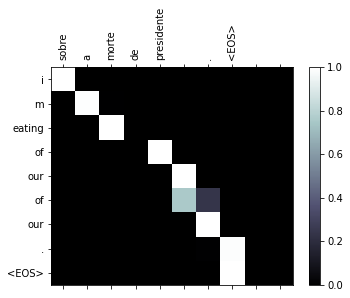

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("sobre a morte de presidente  .")

#evaluateAndShowAttention("elle est trop petit .")

#evaluateAndShowAttention("je ne crains pas de mourir .")

#evaluateAndShowAttention("c est un jeune directeur plein de talent .")

input = eles vao ter que fazer alguma coisa .
output = they re going to have something next . <EOS>


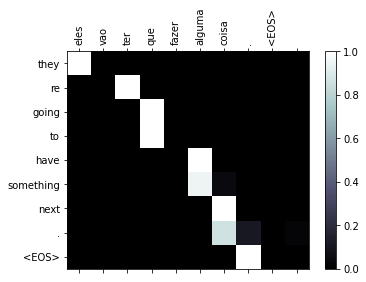

In [ ]:
evaluateAndShowAttention("eles vao ter que fazer alguma coisa .")

In [ ]:
torch.save(encoder1, 'encoder_weights.pth')

In [ ]:
torch.save(attn_decoder1, 'decoder_weights.pth')

In [ ]:
encoder1.load_state_dict(torch.load('encoder_weights.pth'))

<All keys matched successfully>

In [ ]:
attn_decoder1.load_state_dict(torch.load('decoder_weights.pth'))

<All keys matched successfully>